In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

# dataset
from tensorflow.keras.datasets import cifar10

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

frog_label = 6

train_mask = y_train.flatten() != frog_label
test_mask = y_test.flatten() != frog_label

x_train = x_train[train_mask]
y_train = y_train[train_mask]
x_test = x_test[test_mask]
y_test = y_test[test_mask]

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

def add_gaussian_noise(images, mean=0.0, std=0.1):
    noise = np.random.normal(loc=mean, scale=std, size=images.shape)
    noisy_images = images + noise
    noisy_images = np.clip(noisy_images, 0.0, 1.0)
    return noisy_images

x_train_noisy = add_gaussian_noise(x_train, mean=0.0, std=0.1)
x_test_noisy = add_gaussian_noise(x_test, mean=0.0, std=0.1)

def display_images(original, noisy, num_images=10):
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        # Original images
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(original[i])
        plt.title("Original")
        plt.axis("off")

        # Noisy images
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(noisy[i])
        plt.title("Noisy")
        plt.axis("off")
    plt.show()

# display_images(x_train, x_train_noisy)
# display_images(x_test, x_test_noisy)

np.savez_compressed('cifar10_noisy_data.npz', 
                    x_train_noisy=x_train_noisy, 
                    y_train=y_train, 
                    x_test_noisy=x_test_noisy, 
                    y_test=y_test)

print("Noisy CIFAR-10 dataset saved as 'cifar10_noisy_data.npz'.")

Noisy CIFAR-10 dataset saved as 'cifar10_noisy_data.npz'.


In [3]:
# Loading the noisy compressed images
dataset  = np.load("cifar10_noisy_data.npz")
x_train_noisy = dataset["x_train_noisy"]
y_train = dataset["y_train"]
x_test_noisy = dataset["x_test_noisy"]
y_test = dataset["y_test"]

In [4]:
# View sizes of image sets
print(f"Original train data size: {x_train.shape}")
print(f"Original + Noise train data size: {x_train_noisy.shape}")
print(f"Original label train data size: {y_train.shape}\n")

print(f"Original test data size: {x_test.shape}")
print(f"Original + Noise test data size: {x_test_noisy.shape}")
print(f"Original label test data size: {y_test.shape}")

Original train data size: (45000, 32, 32, 3)
Original + Noise train data size: (45000, 32, 32, 3)
Original label train data size: (45000, 1)

Original test data size: (9000, 32, 32, 3)
Original + Noise test data size: (9000, 32, 32, 3)
Original label test data size: (9000, 1)


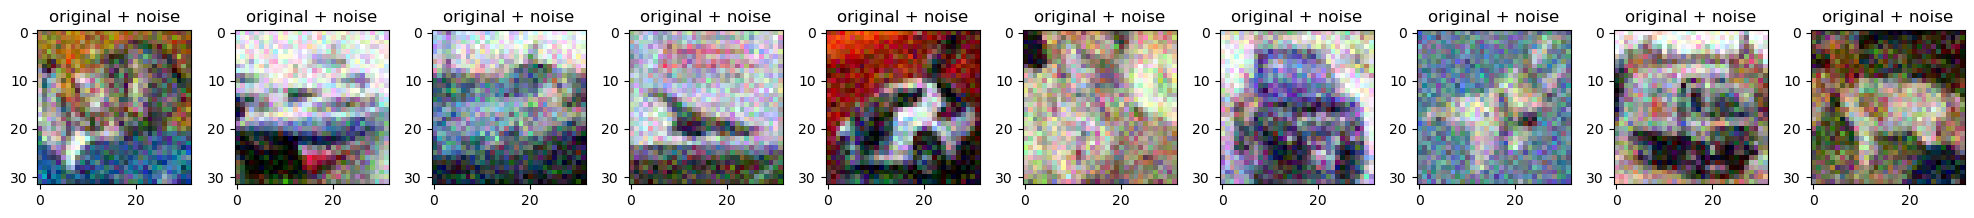

In [5]:
n = 10
plt.figure(figsize=(25, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

In [6]:
class Denoise(Model):
  def __init__(self, **kwargs):
    super(Denoise, self).__init__(**kwargs)
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(32, 32, 3)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.BatchNormalization(), # improves training stability and speed
      layers.ReLU(),
      layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
      layers.BatchNormalization(),
      layers.ReLU(),
      layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),
      layers.BatchNormalization(),
      layers.ReLU(),
      layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2),
      layers.BatchNormalization(),
      layers.ReLU()
      ])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=2),
      layers.BatchNormalization(),
      layers.ReLU(),
      layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2),
      layers.BatchNormalization(),
      layers.ReLU(),
      layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2),
      layers.BatchNormalization(),
      layers.ReLU(),
      layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.BatchNormalization(),
      layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')
      ])

  def call(self, x):
    
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

  def get_config(self):
    config = super(Denoise, self).get_config()
    config.update({})
    return config


In [7]:
# Uncomment for training
# Model 1 training (MSE)
dae = Denoise()
dae.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics=['accuracy', 'mse'])
history = dae.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size = 128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

# Saving the model
dae.save('model1.keras')


# Model 1 training (BCE)
dae2 = Denoise()
dae2.compile(optimizer='adam', loss=losses.BinaryCrossentropy(), metrics=['accuracy','mse'])

history2 = dae2.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size = 128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

# Save the model
dae2.save('model2.keras')


# Model 3 training (unsupervised)
dae3 = Denoise()
dae3.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics=['accuracy','mse'])

history3 = dae3.fit(x_train_noisy, x_train_noisy,
                epochs=100,
                batch_size = 128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test_noisy))

# Save the model
dae3.save('model3.keras')

Epoch 1/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.4269 - loss: 0.0386 - mse: 0.0386 - val_accuracy: 0.4338 - val_loss: 0.0153 - val_mse: 0.0153
Epoch 2/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 25s 72ms/step - accuracy: 0.4377 - loss: 0.0151 - mse: 0.0151 - val_accuracy: 0.5850 - val_loss: 0.0122 - val_mse: 0.0122
Epoch 3/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - accuracy: 0.6113 - loss: 0.0108 - mse: 0.0108 - val_accuracy: 0.6355 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 4/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - accuracy: 0.6362 - loss: 0.0092 - mse: 0.0092 - val_accuracy: 0.6462 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 5/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - accuracy: 0.6409 - loss: 0.0086 - mse: 0.0086 - val_accuracy: 0.6351 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 6/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 25s 72ms/step - accuracy: 0.6452 - loss: 0.0078 - mse: 0.0078 - val_accuracy: 0.6528 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 7/100
352/352 ━━

In [27]:
# Load the models

# Model 1
dae = tf.keras.models.load_model('model1.keras', custom_objects={'Denoise': Denoise})
dae.evaluate(x_test_noisy, x_test)

# Model 2
dae2 = tf.keras.models.load_model('model2.keras', custom_objects={'Denoise': Denoise})
dae2.evaluate(x_test_noisy, x_test)

# Model 3 (unsupervised)
dae3 = tf.keras.models.load_model('model3.keras', custom_objects={'Denoise': Denoise})
dae3.evaluate(x_test_noisy, x_test)


282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7782 - loss: 0.0027 - mse: 0.0027
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7866 - loss: 0.5537 - mse: 0.0027
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7613 - loss: 0.0029 - mse: 0.0029


[0.0028815430123358965, 0.7610138654708862, 0.0028815430123358965]

In [28]:
# Useful to view the layers and output shape of each layer

dae.encoder.summary()
dae.decoder.summary()
dae.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 16, 16, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_21 (ReLU)                 │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 8, 8, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 8, 8, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_22 (ReLU)                 │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 4, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_23 (ReLU)                 │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 2, 2, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_24 (ReLU)                 │ (None, 2, 2, 128)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,400 (384.38 KB)

 Trainable params: 97,920 (382.50 KB)

 Non-trainable params: 480 (1.88 KB)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose_12             │ (None, 4, 4, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_25 (ReLU)                 │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_13             │ (None, 8, 8, 64)       │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_26 (ReLU)                 │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_14             │ (None, 16, 16, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_27 (ReLU)                 │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_15             │ (None, 32, 32, 16)     │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 32, 32, 3)      │           435 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 245,859 (960.39 KB)

 Trainable params: 245,379 (958.51 KB)

 Non-trainable params: 480 (1.88 KB)

Model: "denoise"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)       │ (None, 2, 2, 128)      │        98,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (None, 32, 32, 3)      │       245,859 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,030,859 (3.93 MB)

 Trainable params: 343,299 (1.31 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 686,600 (2.62 MB)

### (Optional) graphs to look at metrics of the trained models
These can only be plotted when the models are trained and not loaded

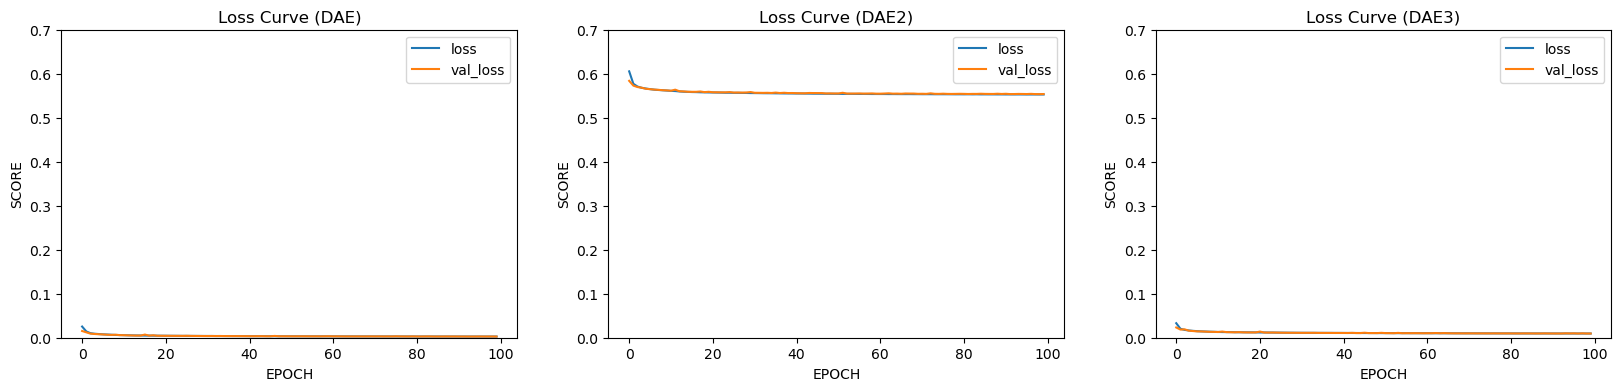

In [8]:
f, (ax, bx, cx) = plt.subplots(1, 3, figsize=(20,4))

ax.plot(history.epoch, history.history['loss'], label='loss')
ax.plot(history.epoch, history.history['val_loss'], label='val_loss')
ax.set_title("Loss Curve (DAE)")
ax.legend()
ax.set_xlabel("EPOCH")
ax.set_ylabel("SCORE")
ax.set_ylim(0, 0.7)

bx.plot(history2.epoch, history2.history['loss'], label='loss')
bx.plot(history2.epoch, history2.history['val_loss'], label='val_loss')
bx.set_title("Loss Curve (DAE2)")
bx.legend()
bx.set_xlabel("EPOCH")
bx.set_ylabel("SCORE")
bx.set_ylim(0, 0.7)

cx.plot(history3.epoch, history3.history['loss'], label='loss')
cx.plot(history3.epoch, history3.history['val_loss'], label='val_loss')
cx.set_title("Loss Curve (DAE3)")
cx.legend()
cx.set_xlabel("EPOCH")
cx.set_ylabel("SCORE")
cx.set_ylim(0, 0.7)
plt.show()


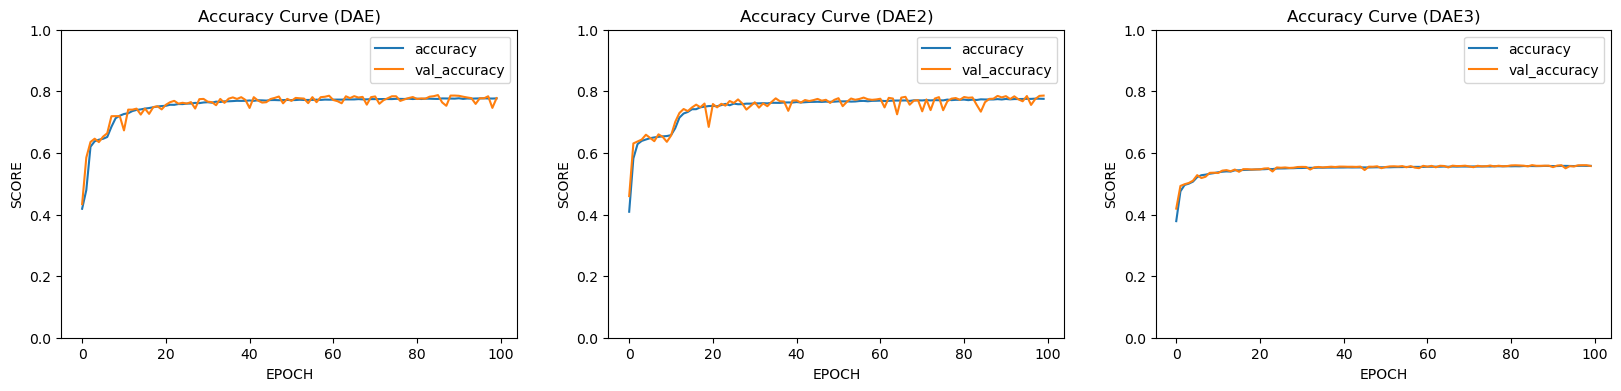

In [9]:
f, (ax, bx, cx) = plt.subplots(1, 3, figsize=(20,4))

ax.plot(history.epoch, history.history['accuracy'], label='accuracy')
ax.plot(history.epoch, history.history['val_accuracy'], label='val_accuracy')
ax.set_title("Accuracy Curve (DAE)")
ax.legend()
ax.set_xlabel("EPOCH")
ax.set_ylabel("SCORE")
ax.set_ylim(0, 1.0)

bx.plot(history2.epoch, history2.history['accuracy'], label='accuracy')
bx.plot(history2.epoch, history2.history['val_accuracy'], label='val_accuracy')
bx.set_title("Accuracy Curve (DAE2)")
bx.legend()
bx.set_xlabel("EPOCH")
bx.set_ylabel("SCORE")
bx.set_ylim(0, 1.0)

cx.plot(history3.epoch, history3.history['accuracy'], label='accuracy')
cx.plot(history3.epoch, history3.history['val_accuracy'], label='val_accuracy')
cx.set_title("Accuracy Curve (DAE3)")
cx.legend()
cx.set_xlabel("EPOCH")
cx.set_ylabel("SCORE")
cx.set_ylim(0, 1.0)
plt.show()


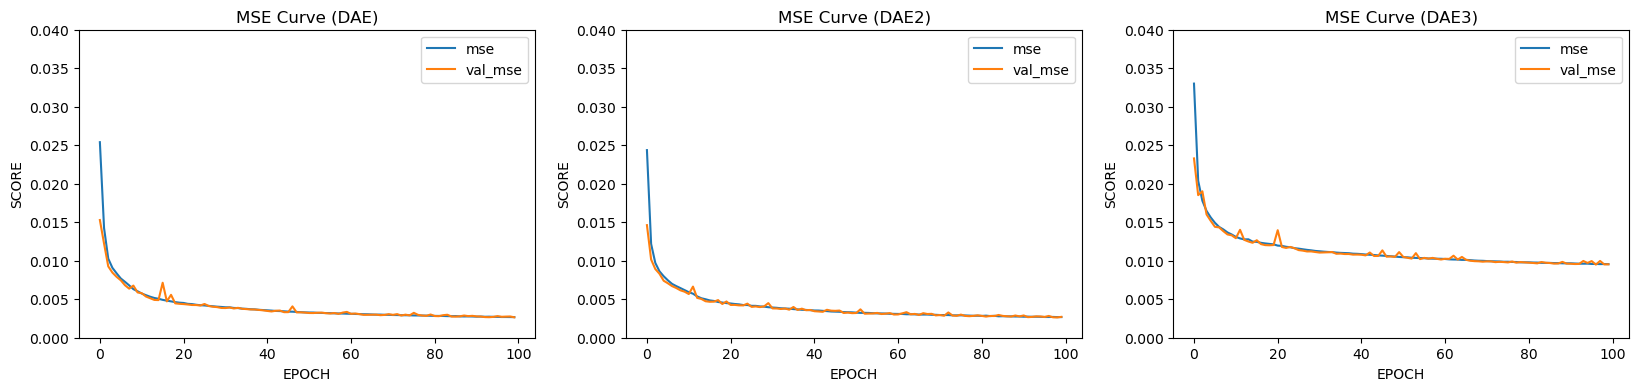

In [10]:
f, (ax, bx, cx) = plt.subplots(1, 3, figsize=(20,4))

ax.plot(history.epoch, history.history['mse'], label='mse')
ax.plot(history.epoch, history.history['val_mse'], label='val_mse')
ax.set_title("MSE Curve (DAE)")
ax.legend()
ax.set_xlabel("EPOCH")
ax.set_ylabel("SCORE")
ax.set_ylim(0, 0.04)

bx.plot(history2.epoch, history2.history['mse'], label='mse')
bx.plot(history2.epoch, history2.history['val_mse'], label='val_mse')
bx.set_title("MSE Curve (DAE2)")
bx.legend()
bx.set_xlabel("EPOCH")
bx.set_ylabel("SCORE")
bx.set_ylim(0, 0.04)

cx.plot(history3.epoch, history3.history['mse'], label='mse')
cx.plot(history3.epoch, history3.history['val_mse'], label='val_mse')
cx.set_title("MSE Curve (DAE3)")
cx.legend()
cx.set_xlabel("EPOCH")
cx.set_ylabel("SCORE")
cx.set_ylim(0, 0.04)
plt.show()


## Run models on noisy images and save output

Once our models are trained, we can use the models to generate the denoised outputs from the noisy data and save them.

In [11]:
denoised1 = dae.predict(x_test_noisy)
denoised2 = dae2.predict(x_test_noisy)
denoised3 = dae3.predict(x_test_noisy)

282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


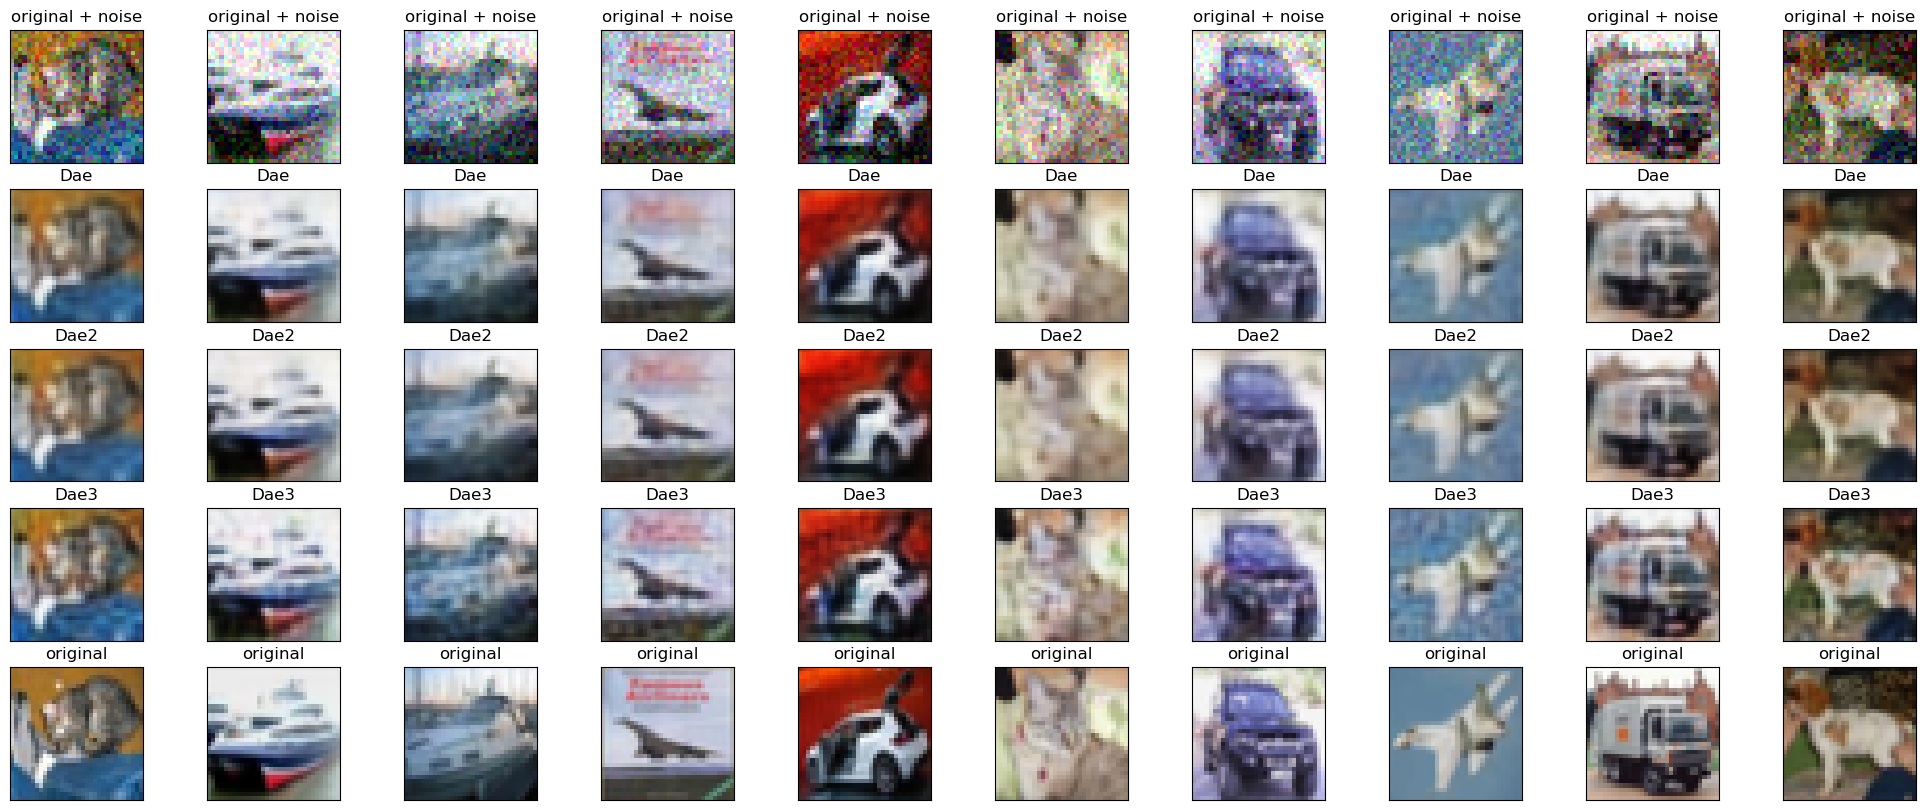

In [29]:
n=10
plt.figure(figsize=(25, 10))

for i in range(n):
    ax = plt.subplot(5, n, i+1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bx = plt.subplot(5, n, i+n+1)
    plt.title("Dae")
    plt.imshow(tf.squeeze(denoised1[i]))
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

    cx = plt.subplot(5, n, i+(2 *n)+1)
    plt.title("Dae2")
    plt.imshow(tf.squeeze(denoised2[i]))
    cx.get_xaxis().set_visible(False)
    cx.get_yaxis().set_visible(False)

    dx = plt.subplot(5, n, i+(3*n)+1)
    plt.title("Dae3")
    plt.imshow(tf.squeeze(denoised3[i]))
    dx.get_xaxis().set_visible(False)
    dx.get_yaxis().set_visible(False)

    ex = plt.subplot(5, n, i+(4*n)+1)
    plt.title("original")
    plt.imshow(tf.squeeze(x_test[i]))
    ex.get_xaxis().set_visible(False)
    ex.get_yaxis().set_visible(False)
plt.show()

In [30]:
np.savez_compressed('cifar10_output.npz', 
                    denoised1=denoised1, 
                    denoised2=denoised2, 
                    denoised3=denoised3)

## Model Evaluation

This sections looks at evaluation the performance of the three models.
This can be done by visually inspecting the denoised images from the model against the original clean image.
We can also use image quality assessment metrics like MSE (Mean Squared Error) and PSNR (Peak Signal-to-Noise Ratio) and SSIM (Structured Similarity Index)


In [31]:
output_dataset  = np.load("cifar10_output.npz")
denoised1 = output_dataset["denoised1"]
denoised2 = output_dataset["denoised2"]
denoised3 = output_dataset["denoised3"]

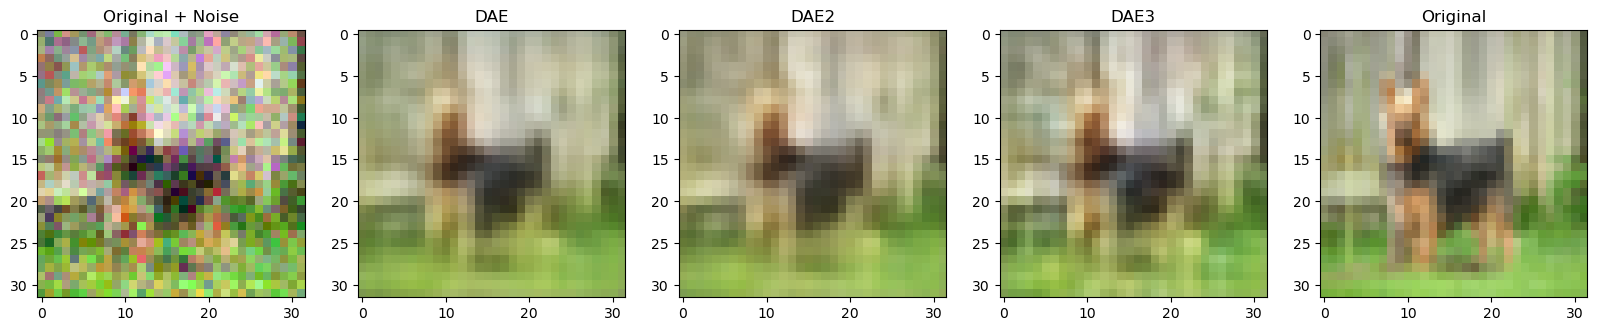

In [32]:
i = 20

plt.figure(figsize=(20, 4))
ax = plt.subplot(1, 5, 1)
plt.imshow(tf.squeeze(x_test_noisy[i]))
ax.set_title("Original + Noise")

bx = plt.subplot(1, 5, 2)
plt.imshow(tf.squeeze(denoised1[i]))
bx.set_title("DAE")

cx = plt.subplot(1, 5, 3)
plt.imshow(tf.squeeze(denoised2[i]))
cx.set_title("DAE2")

dx = plt.subplot(1, 5, 4)
plt.imshow(tf.squeeze(denoised3[i]))
dx.set_title("DAE3")

ex = plt.subplot(1, 5, 5)
plt.imshow(tf.squeeze(x_test[i]))
ex.set_title("Original")

plt.show()

In [33]:
mse_scores = [tf.reduce_mean(tf.reduce_mean(tf.keras.losses.mse(x_test, x), axis=1), axis=1) for x in [x_test_noisy, denoised1, denoised2, denoised3]]
psnr_scores = [tf.image.psnr(x_test, x, max_val=1.0).numpy() for x in [x_test_noisy, denoised1, denoised2, denoised3]]
ssim_scores = [tf.image.ssim(x_test, x, max_val=1.0).numpy() for x in [tf.cast(x_test_noisy, tf.float32), denoised1, denoised2, denoised3]]

print("Noisy, DAE, DAE2, DAE3")
print(f"MSE Scores (MEAN): {np.mean(mse_scores, axis=1)}")
print(f"PSNR Scores (MEAN): {np.mean(psnr_scores, axis=1)}")
print(f"SSIM Scores (MEAN): {np.mean(ssim_scores, axis=1)}")

Noisy, DAE, DAE2, DAE3
MSE Scores (MEAN): [0.00929472 0.00265164 0.00270987 0.00288154]
PSNR Scores (MEAN): [20.330408 26.101013 26.000257 25.586998]
SSIM Scores (MEAN): [0.654577   0.8583499  0.8563737  0.84334236]


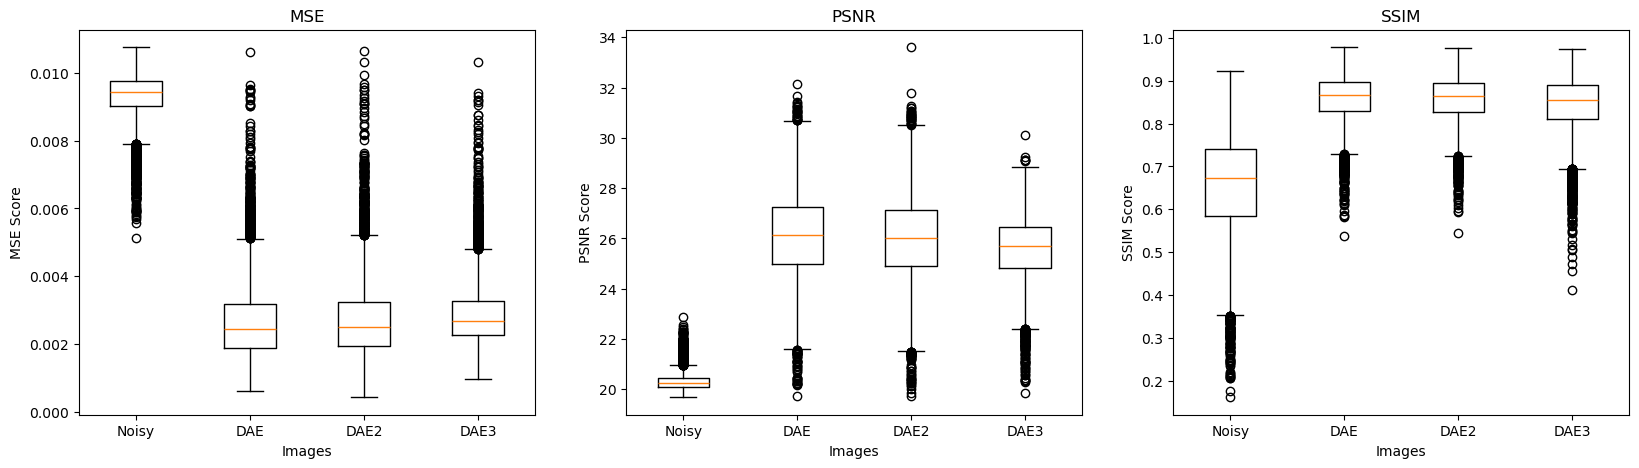

In [34]:
labels = ["Noisy", "DAE", "DAE2", "DAE3"]

plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
plt.title("MSE")
plt.boxplot(mse_scores, labels = labels)
plt.xlabel("Images")
plt.ylabel("MSE Score")

plt.subplot(1,3,2)
plt.title("PSNR")
plt.boxplot(psnr_scores, labels = labels)
plt.xlabel("Images")
plt.ylabel("PSNR Score")

plt.subplot(1,3,3)
plt.title("SSIM")
plt.boxplot(ssim_scores, labels = labels)
plt.xlabel("Images")
plt.ylabel("SSIM Score")

plt.show()

## Non CIFAR images

Using TensorFlow flowers dataset for our NON-CIFAR image

From sample: https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub

In [20]:
import pathlib
import glob
import cv2

data_file = tf.keras.utils.get_file(
  'flower_photos.tgz',
  'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
  cache_dir='.',
   extract=True)

data_root = pathlib.Path(data_file).with_suffix('')

# Downloads the ImageNet images

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step


In [21]:
image_paths = glob.glob('datasets/**/*.jpg',recursive =True)
clean_images = np.array([cv2.resize(cv2.imread(i), (32, 32)) for i in image_paths]) # inter linear default interpolation
for i in range(len(clean_images)):
    clean_images[i] = cv2.cvtColor(clean_images[i], cv2.COLOR_RGB2BGR)

clean_images = clean_images.astype('float32') / 255.0
noisy_images = add_gaussian_noise(clean_images, mean=0.0, std=0.1)

In [22]:
denoised_new1 = dae.predict(noisy_images)
denoised_new2 = dae2.predict(noisy_images)
denoised_new3 = dae3.predict(noisy_images)

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


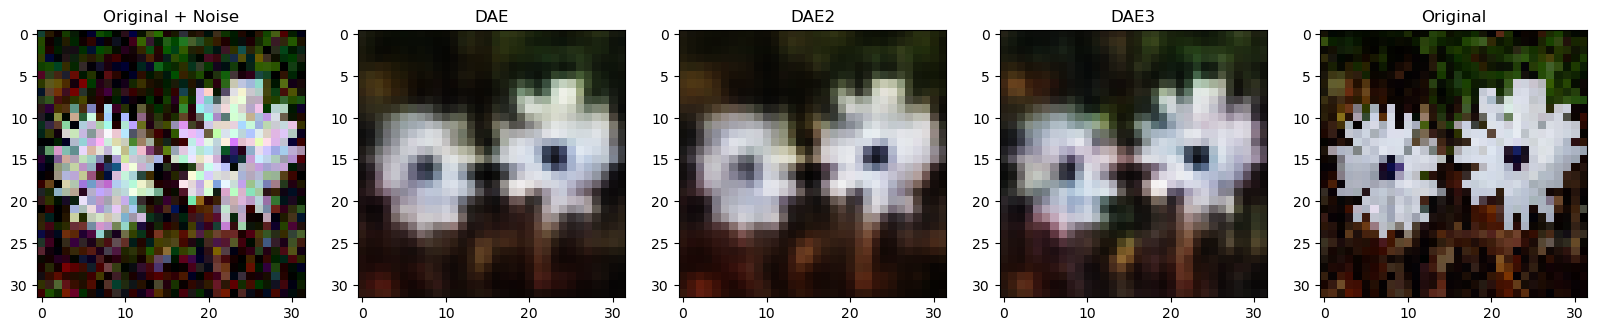

In [23]:
i = 40

plt.figure(figsize=(20, 4))
ax = plt.subplot(1, 5, 1)
plt.imshow(tf.squeeze(noisy_images[i]))
ax.set_title("Original + Noise")

bx = plt.subplot(1, 5, 2)
plt.imshow(tf.squeeze(denoised_new1[i]))
bx.set_title("DAE")

cx = plt.subplot(1, 5, 3)
plt.imshow(tf.squeeze(denoised_new2[i]))
cx.set_title("DAE2")

dx = plt.subplot(1, 5, 4)
plt.imshow(tf.squeeze(denoised_new3[i]))
dx.set_title("DAE3")

ex = plt.subplot(1, 5, 5)
plt.imshow(tf.squeeze(clean_images[i]))
ex.set_title("Original")

plt.show()

In [24]:
mse_scores2 = [tf.reduce_mean(tf.reduce_mean(tf.keras.losses.mse(clean_images, x), axis=1), axis=1) for x in [noisy_images, denoised_new1, denoised_new2, denoised_new3]]
psnr_scores2 = [tf.image.psnr(clean_images, x, max_val=1.0).numpy() for x in [noisy_images, denoised_new1, denoised_new2, denoised_new3]]
ssim_scores2 = [tf.image.ssim(clean_images, x, max_val=1.0).numpy() for x in [tf.cast(noisy_images, tf.float32), denoised_new1, denoised_new2, denoised_new3]]

print("Noisy, DAE, DAE2, DAE3")
print(f"MSE Scores (MEAN): {np.mean(mse_scores2, axis=1)}")
print(f"PSNR Scores (MEAN): {np.mean(psnr_scores2, axis=1)}")
print(f"SSIM Scores (MEAN): {np.mean(ssim_scores2, axis=1)}")

Noisy, DAE, DAE2, DAE3
MSE Scores (MEAN): [0.00861421 0.01291677 0.01307721 0.01250256]
PSNR Scores (MEAN): [20.669968 19.636621 19.584972 19.699596]
SSIM Scores (MEAN): [0.75634    0.63618267 0.63069916 0.65164393]


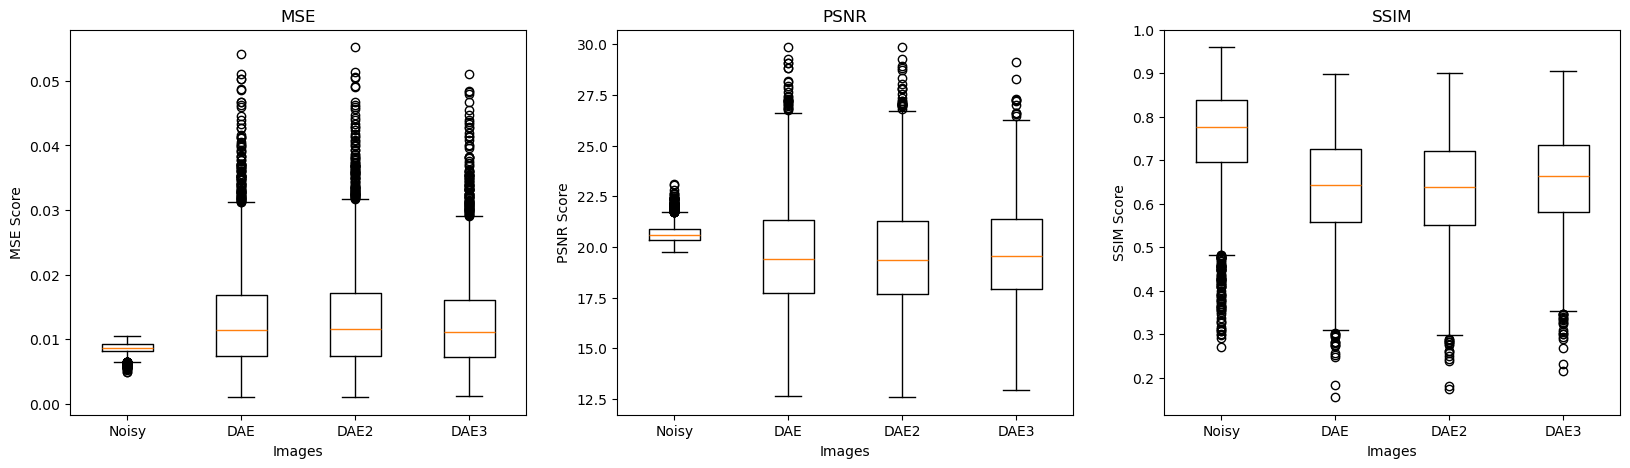

In [25]:
labels = ["Noisy", "DAE", "DAE2", "DAE3"]

plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
plt.title("MSE")
plt.boxplot(mse_scores2, labels = labels)
plt.xlabel("Images")
plt.ylabel("MSE Score")

plt.subplot(1,3,2)
plt.title("PSNR")
plt.boxplot(psnr_scores2, labels = labels)
plt.xlabel("Images")
plt.ylabel("PSNR Score")

plt.subplot(1,3,3)
plt.title("SSIM")
plt.boxplot(ssim_scores2, labels = labels)
plt.xlabel("Images")
plt.ylabel("SSIM Score")

plt.show()